# Multi-Agent Deep AI Finance Researcher from Scratch

Hierarchical multi-agent system with Orchestrator, Researcher, and Editor agents for deep financial research.

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from dotenv import load_dotenv
load_dotenv()

from typing import Annotated
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from scripts.rag_tools import hybrid_search, live_finance_researcher
from scripts.agent_utils import stream_agent_response

from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage, AIMessage, ToolMessage

In [3]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from scripts.file_tools import (
    DeepAgentState,
    ls,
    read_file,
    write_file,
    cleanup_files,
    generate_hash,
    _disk_path
)

from scripts.prompts import (
    ORCHESTRATOR_PROMPT,
    RESEARCHER_PROMPT,
    EDITOR_PROMPT,
)

## Initialize Components and Create Worker Agents

In [4]:
from scripts.llm import llm

conn = sqlite3.connect("data/deep_finance_researcher.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [5]:
# Researcher Agent - uses RAG and live finance tools
researcher_agent = create_agent(
    model=llm,
    tools=[ls, write_file, read_file, hybrid_search, live_finance_researcher],
    system_prompt=RESEARCHER_PROMPT,
    state_schema=DeepAgentState,
)

# Editor Agent
editor_agent = create_agent(
    model=llm,
    tools=[ls, read_file, write_file, cleanup_files],
    system_prompt=EDITOR_PROMPT,
    state_schema=DeepAgentState,
)

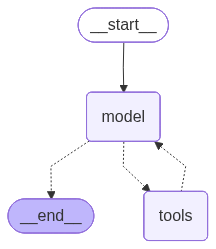

In [6]:
researcher_agent

## Define Orchestrator Tools

In [7]:
@tool
def write_research_plan(
    thematic_questions: list[str],
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """
    Write the high-level research plan with major thematic questions.

    Args:
        thematic_questions: List of 3-5 major thematic questions
        state: Injected agent state
        tool_call_id: Tool call ID

    Returns:
        Command with ToolMessage confirming the plan was written
    """
    content = "# Research Plan\n\n"

    content = content + "## User Query\n"
    content = content + state["messages"][-1].text + "\n\n"

    content = content + "## Thematic Questions\n\n"
    for i, question in enumerate(thematic_questions, 1):
        content = content + f"{i}. {question}\n"

    path = _disk_path(state, "research_plan.md")
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

    msg = f"[RESEARCH PLAN WRITTEN] research_plan.md with {len(thematic_questions)} thematic questions"
    return Command(update={"messages": [ToolMessage(msg, tool_call_id=tool_call_id)]})



In [8]:
@tool
def run_researcher(
            theme_id: int,
            thematic_question: str,
            state: Annotated[DeepAgentState, InjectedState],
            max_retries: int = 2
        ):
    """
    Run a single Research agent for ONE thematic question.

    Args:
        theme_id: The theme number (1, 2, 3, etc.)
        thematic_question: The specific thematic question to research
        state: Injected agent state
        max_retries: Number of retry attempts

    Returns:
        Status string for the orchestrator
    """
    
    file_hash = generate_hash(f"{theme_id}_{thematic_question}")

    ai_message_instruction = f"""[THEME {theme_id}] {thematic_question}

                        Save research to: researcher/{file_hash}_theme.md
                        Save sources to: researcher/{file_hash}_sources.txt
                        """

    sub_state: DeepAgentState = {
        "messages": state["messages"] + [AIMessage(ai_message_instruction)],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }

    for attempt in range(max_retries + 1):
        try:
            researcher_agent.invoke(sub_state)
            return f"✓ Theme {theme_id} research completed (hash: {file_hash})"
        except Exception:
            print(f"Failed. Trying #{attempt} times")

    return f"✗ Theme {theme_id} failed after {max_retries + 1} attempts"


In [9]:
@tool
def run_editor(state: Annotated[DeepAgentState, InjectedState]) -> str:
    """
    Run the Editor agent to synthesize all research into final report.

    Args:
        state: Injected agent state

    Returns:
        Status string
    """
    sub_state: DeepAgentState = {
        "messages": [HumanMessage(content="Read research_plan.md and all files in the researcher/ folder, then synthesize everything into a comprehensive report.md file.")],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }
    editor_agent.invoke(sub_state)
    return "Editor completed. Final report is written to report.md."

## Create Orchestrator Agent

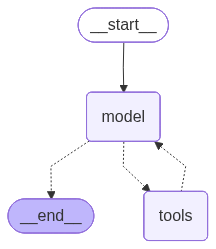

In [10]:
orchestrator_agent = create_agent(
    model=llm,
    tools=[write_research_plan, run_researcher, run_editor, cleanup_files],
    system_prompt=ORCHESTRATOR_PROMPT,
    state_schema=DeepAgentState,
    checkpointer=checkpointer
)

orchestrator_agent

## Examples

In [11]:
import importlib
import scripts.llm
# Force reload the module
importlib.reload(scripts.llm)
from scripts.llm import llm
# Verify again
print(f"Current LLM Type: {type(llm)}")

Current LLM Type: <class 'langchain_openai.chat_models.base.ChatOpenAI'>


In [15]:
import importlib
import scripts.llm
import scripts.rag_tools
import scripts.file_tools

# 1. Force reload all modules to pick up the OpenAI switch
importlib.reload(scripts.llm)
importlib.reload(scripts.rag_tools)
importlib.reload(scripts.file_tools)

# 2. Re-import the fresh objects
from scripts.llm import llm
from scripts.rag_tools import hybrid_search, live_finance_researcher
from scripts.file_tools import ls, read_file, write_file, cleanup_files, DeepAgentState

# 3. RE-CREATE the agents (This is the most important part!)
# Note: Ensure RESEARCHER_PROMPT, EDITOR_PROMPT, and ORCHESTRATOR_PROMPT are already defined in your notebook.
researcher_agent = create_agent(
    model = llm, # Now guaranteed to be OpenAI
    tools=[ls, write_file, read_file, hybrid_search, live_finance_researcher],
    system_prompt=RESEARCHER_PROMPT,
    state_schema=DeepAgentState,
)

editor_agent = create_agent(
    model=llm,
    tools=[ls, read_file, write_file, cleanup_files],
    system_prompt=EDITOR_PROMPT,
    state_schema=DeepAgentState,
)

orchestrator_agent = create_agent(
    model=llm,
    tools=[write_research_plan, run_researcher, run_editor, cleanup_files],
    system_prompt=ORCHESTRATOR_PROMPT,
    state_schema=DeepAgentState,
    checkpointer=checkpointer
)

print(f"✅ Success! All agents and tools are now using: {type(llm)}")

✅ Success! All agents and tools are now using: <class 'langchain_openai.chat_models.base.ChatOpenAI'>


In [ ]:
from scripts.agent_utils import stream_agent_response
# Research query that requires live data
query = "Do a detailed analysis of Amazon's financial performance in 2023 and 2024?"
print("--- Starting Multi-Agent Research ---")
stream_agent_response(
    orchestrator_agent,
    query,
    thread_id="test_verification_002",
    user_id="user_admin"
)

In [ ]:
from scripts.agent_utils import stream_agent_response

# Simple question - direct answer
stream_agent_response(
    orchestrator_agent,
    "What is a 10-K report?",
    thread_id="thread_005",
    user_id="user_219",
)

A 10-K report is a comprehensive annual filing that publicly traded companies in the United States are required to submit to the U.S. Securities and Exchange Commission (SEC). It provides a detailed overview of a company's financial performance over the past fiscal year and includes information such as:

1. **Business Overview**: Description of the company's operations, including its products and services.
2. **Financial Data**: Audited financial statements, including the balance sheet, income statement, and cash flow statement.
3. **Management's Discussion and Analysis (MD&A)**: Insights into the financial results and any future risks or opportunities from the perspective of company management.
4. **Risk Factors**: Identification of potential risks that may affect future performance.
5. **Governance and Executive Compensation**: Information about the company's executive team, board of directors, and their compensation.

The 10-K is intended to give investors a thorough analysis of the

In [ ]:
# Complex financial research
stream_agent_response(
    orchestrator_agent,
    "Do a detailed analysis of Amazon's financial performance in 2023 and 2024",
    thread_id="thread_903",
    user_id="user_712"
)